In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
%matplotlib inline 
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

import os 
from keras.layers import Conv1D, MaxPooling1D, SpatialDropout1D
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from keras.utils.vis_utils import plot_model
from keras import initializers
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

Using TensorFlow backend.
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
train = pd.read_csv("data/7C_train.csv", sep="\t")
valid = pd.read_csv("data/7C_valid.csv", sep="\t")

y_train = train["Compartment Prediction"]
y_valid = valid["Compartment Prediction"]

x_train = train["Sequence"].copy()
x_valid = valid["Sequence"].copy()

In [3]:
print(len(x_train), 'train sequences')
print(len(x_valid), 'valid sequences')

2347 train sequences
587 valid sequences


In [4]:
max_len = len(max(x_train, key=len))
print(max_len)

1498


In [5]:
# all amino acids (in blosum order)
aa = "*ARNDCQEGHILKMFPSTWYVU"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

## One hot encoding of Labels

In [7]:
# NB: DO NOT USE SET, IT CHANGES ORDER OF CATEGORY EVERYTIME I RUN THE NOTEBOOK!!!!
#cat = list(set(y_train))
cat = ['ER',
 'Golgi',
 'Mitochondrion',
 'Endosome',
 'Large Protein Complex',
 'Plasma membrane',
 'Lysosome']

In [8]:
tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]   

In [9]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [10]:
y_train_indices = cat_to_indices(y_train)
y_valid_indices = cat_to_indices(y_valid)

y_train_OH = convert_to_one_hot(y_train_indices, C = tot_cat)
y_valid_OH = convert_to_one_hot(y_valid_indices, C = tot_cat)

## X_train processing: 
### From Sequences to list of indices

In [11]:
# Function to convert sequences to array of indices. I will that that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = []
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        seq_ind = []
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            seq_ind.append(aa_to_int[seq_aa[w]])
            
        X_indices.append(seq_ind)
            
    ### END CODE HERE ###
    
    return X_indices

In [12]:
x_train_indices = seq_to_indices(x_train, aa_to_int, max_len)
x_valid_indices = seq_to_indices(x_valid, aa_to_int, max_len)

In [13]:
# Pad sequences
# By default, the padding is added before the sequence
x_train_pad = sequence.pad_sequences(x_train_indices, maxlen=max_len, value=aa_to_int["*"])
x_valid_pad = sequence.pad_sequences(x_valid_indices, maxlen=max_len, value=aa_to_int["*"])
print('x_train shape:', x_train_pad.shape)
print('x_valid shape:', x_valid_pad.shape)

x_train shape: (2347, 1498)
x_valid shape: (587, 1498)


In [14]:
# One hot to label 
#Y is list of OH vector
def OH_to_label_indices(Y):
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

In [15]:
def indices_to_cat(Y):
    Y_cat = []
    for i in range(len(Y)):
        Y_cat.append(int_to_cat[Y[i]])
    return Y_cat

## Model 1

In [16]:
max_features = tot_aa + 1
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 48
# Convolution
filters = 20
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/model1_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=60,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Instructions for updating:
Use tf.cast instead.
Train on 2347 samples, validate on 587 samples
Epoch 1/60
2347/2347 [==============================] - 199s 85ms/step - loss: 1.4541 - accuracy: 0.5219 - val_loss: 1.3758 - val_accuracy: 0.5264

Epoch 00001: val_loss improved from inf to 1.37576, saving model to models/model1_weights.hdf5
Epoch 2/60
2347/2347 [==============================] - 189s 80ms/step - loss: 1.3671 - accuracy: 0.5279 - val_loss: 1.3181 - val_accuracy: 0.5332

Epoch 00002: val_loss improved from 1.37576 to 1.31814, saving model to models/model1_weights.hdf5
Epoch 3/60
2347/2347 [==============================] - 192s 82ms/step - loss: 1.3199 - accuracy: 0.5390 - val_loss: 1.2881 - val_accuracy: 0.5400

Epoch 00003: val_loss improved from 1.31814 to 1.28810, saving model to models/model1_weights.hdf5
Epoch 4/60
2347/2347 [==============================] - 189s 81ms/step - loss: 1.2826 - accuracy: 0.5594 - val_loss: 1.1880 - val_accuracy: 0.5639

Epoch 00004: val_los


Epoch 00035: val_loss did not improve from 0.78340
Epoch 36/60
2347/2347 [==============================] - 185s 79ms/step - loss: 0.7056 - accuracy: 0.7806 - val_loss: 0.7993 - val_accuracy: 0.7581

Epoch 00036: val_loss did not improve from 0.78340
Epoch 37/60
2347/2347 [==============================] - 185s 79ms/step - loss: 0.7088 - accuracy: 0.7763 - val_loss: 0.7991 - val_accuracy: 0.7462

Epoch 00037: val_loss did not improve from 0.78340
Epoch 38/60
2347/2347 [==============================] - 187s 80ms/step - loss: 0.7415 - accuracy: 0.7686 - val_loss: 0.7828 - val_accuracy: 0.7479

Epoch 00038: val_loss improved from 0.78340 to 0.78281, saving model to models/model1_weights.hdf5
Epoch 39/60
2347/2347 [==============================] - 184s 78ms/step - loss: 0.6921 - accuracy: 0.7780 - val_loss: 0.7872 - val_accuracy: 0.7513

Epoch 00039: val_loss did not improve from 0.78281
Epoch 40/60
2347/2347 [==============================] - 185s 79ms/step - loss: 0.6727 - accuracy: 0

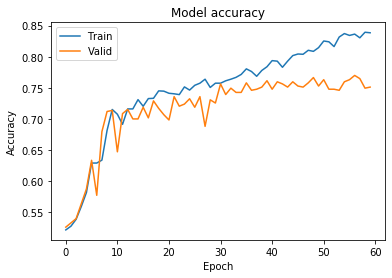

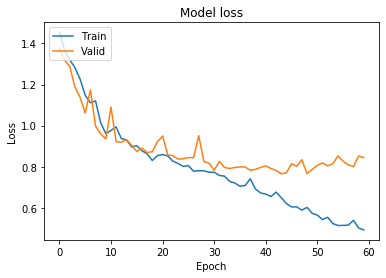

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [19]:
model = load_model('models/model1_weights.hdf5')
model.evaluate(x_valid_pad, y_valid_OH, verbose=0)

[0.7658405110519221, 0.7512776851654053]

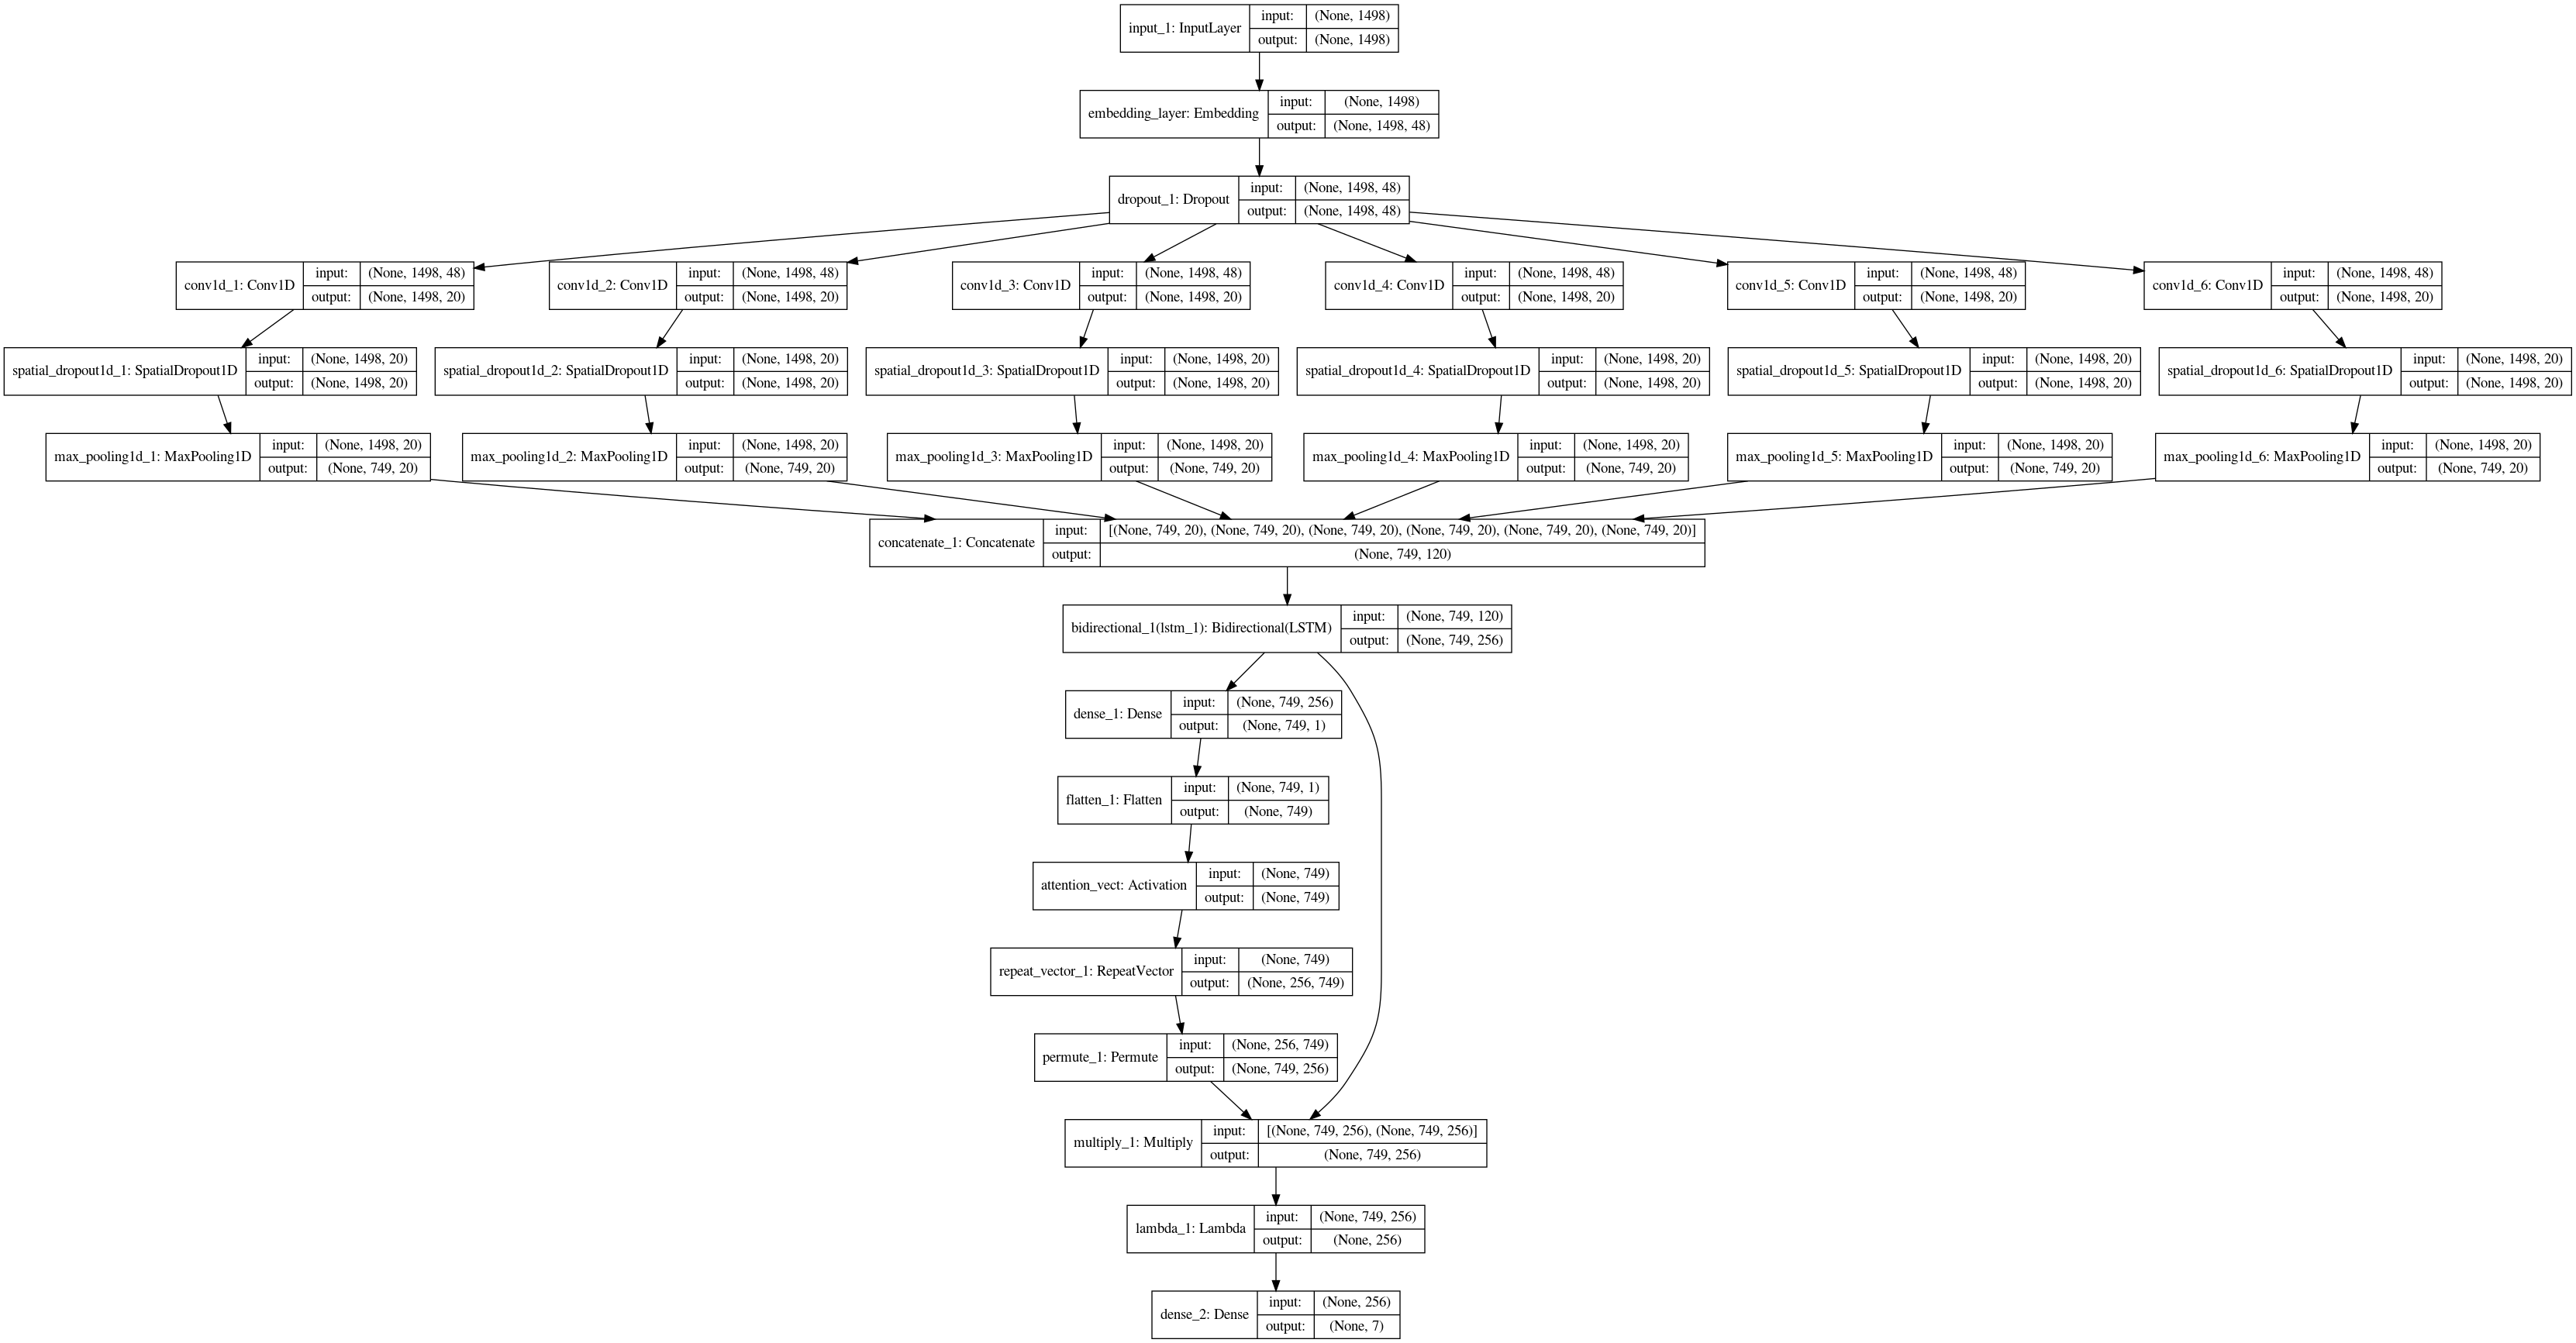

In [20]:
plot_model(model, to_file='models/model1_plot.png', show_shapes=True, show_layer_names=True)

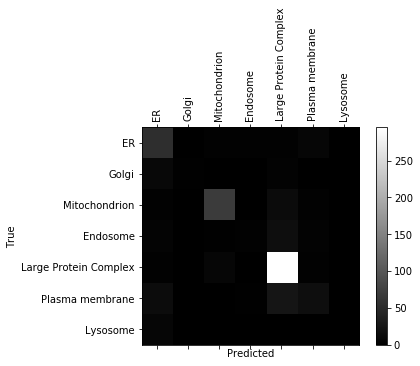

In [21]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_label = indices_to_cat(y_pred_indices)

conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

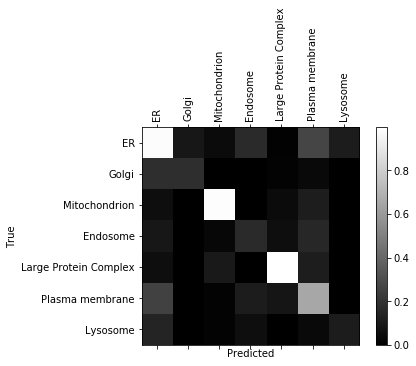

In [22]:
conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=1)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
conf_mx

array([[ 54,   1,   3,   3,   3,   7,   1],
       [ 10,   2,   0,   0,   4,   1,   0],
       [  3,   0,  69,   0,  13,   3,   0],
       [  5,   0,   2,   3,  17,   4,   0],
       [  3,   0,   7,   0, 295,   3,   0],
       [ 14,   0,   1,   2,  25,  17,   0],
       [  8,   0,   1,   1,   0,   1,   1]])

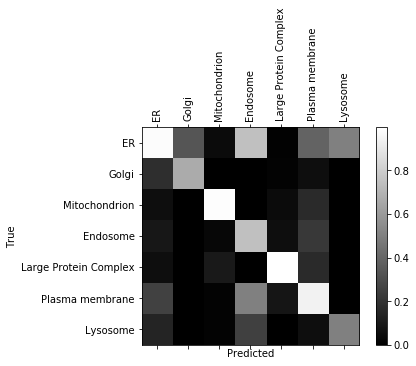

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=0)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
print(classification_report(y_valid, y_pred_label))

                       precision    recall  f1-score   support

                   ER       0.56      0.75      0.64        72
             Endosome       0.33      0.10      0.15        31
                Golgi       0.67      0.12      0.20        17
Large Protein Complex       0.83      0.96      0.89       308
             Lysosome       0.50      0.08      0.14        12
        Mitochondrion       0.83      0.78      0.81        88
      Plasma membrane       0.47      0.29      0.36        59

             accuracy                           0.75       587
            macro avg       0.60      0.44      0.45       587
         weighted avg       0.72      0.75      0.72       587



original shape:    (23, 48)
transformed shape: (23, 2)


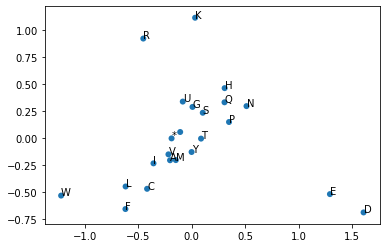

In [26]:
embedding = model.get_layer('embedding_layer').get_weights()
embedding = embedding[0]

# PCA plots of Embedding 
pca = PCA(n_components=2)
pca.fit(embedding)
embedding_pca = pca.transform(embedding)
print("original shape:   ", embedding.shape)
print("transformed shape:", embedding_pca.shape)
fig, ax = plt.subplots()
plt.scatter(embedding_pca[:, 0], embedding_pca[:, 1], edgecolor='none')
aaL = list(aa)
for i in range(len(aaL)):
    ax.annotate(aaL[i], (embedding_pca[:, 0][i], embedding_pca[:, 1][i]))
    
plt.show()

## Attention Layer Analysis

In [57]:
model = Model(inputs=model.input,
              outputs=[model.output, model.get_layer('attention_vect').output])
outputs = model.predict(x_valid_pad)
model_outputs = outputs[0]
attention_outputs = outputs[1]

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, 'Attention Distribution')

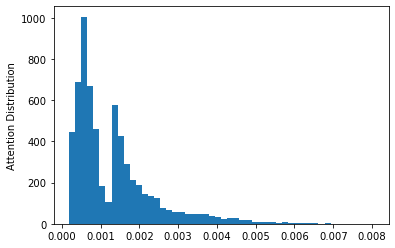

In [58]:
attention_distrib = np.concatenate( attention_outputs, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


Text(0, 0.5, 'Attention Distribution')

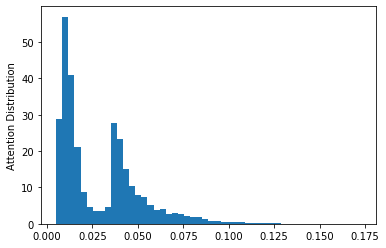

In [59]:
# Normalize attention values 
norm_attention = []
for seq in attention_outputs:
    norm_attention.append(seq / np.linalg.norm(seq))
    
attention_distrib = np.concatenate( norm_attention, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

### Attention visualization for a single sequence

Because I pooled (pool size = 2) attention is len = 750. 
So I need to duplicate every values.

In [60]:
def indices_to_seq(X):
    seq = ''
    for i in range(len(X)):
        seq +=int_to_aa[X[i]] 
    return seq

In [78]:
# pool_size = 2
Attention_1500 = []
A = []
for x in norm_attention:
    for i in range(len(x)):
        A.append(x[i])
        A.append(x[i])
    Attention_1500.append(np.array(A))
    A = []

In [79]:
# Number of highest values to select
nb_max = 50
max_att_indexes = []
for seq in Attention_1500:
    max_att_indexes.append(np.sort(np.argpartition(seq, -nb_max)[-nb_max:]))
max_att_nopad = []    
for x in range(len(x_valid)):
    max_att_nopad.append(max_att_indexes[x]-(1500-len(x_valid[x])))

In [80]:
X = 3

def color_charvals(s):
    r = 255-int(s.val*255)
    color = rgb_to_hex((255,255 , r))
    return 'background-color: %s' % color

max_ind = max_att_nopad[X]
max_vect = np.zeros(len(x_valid[X]))
for val in max_ind:
    max_vect[val] = 1
# match each aa and attention
char_vals = [CharVal(c, v) for c, v in 
             zip(x_valid[X], max_vect)]

char_df = pd.DataFrame(char_vals).transpose()
# apply coloring values
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,M,E,D,E,R,S,F,S,D,I,C,G,G,R,L,A,L,Q,R,R,Y,Y,S,P,S,C,R,E,F,C,L,S,C,P,R,L,S,L,R,S,L,T,A,V,T,C,T,V,W,L,A,A,Y,G,L,F,T,L,C,E,N,S,M,I,L,S,A,A,I,F,I,T,L,L,G,L,L,G,Y,L,H,F,V,K,I,D,Q,E,T,L,L,I,I,D,S,L,G,I,Q,M,T,S,S,Y,A,S,G,K,E,S,T,T,F,I,E,M,G,K,V,K,D,I,V,I,N,E,A,I,Y,M,Q,K,V,I,Y,Y,L,C,I,L,L,K,D,P,V,E,P,H,G,I,S,Q,V,V,P,V,F,Q,S,A,K,P,R,L,D,C,L,I,E,V,Y,R,S,C,Q,E,I,L,A,H,Q,K,A,T,S,T,S,P


In [81]:
y_valid[X]

'Large Protein Complex'

## Error Analysis

In [112]:
# Add the prediction to Valid dataframe
valid["Model Prediction"] = y_pred_label

In [119]:
valid.groupby(["Compartment Prediction", "Model Prediction"]).count()/len(valid)*100

Lead Protein ID  \
Compartment Prediction Model Prediction                         
Actin binding proteins ER                            0.132275   
                       Large Protein Complex         1.587302   
ER                     ER                            7.142857   
                       Endosome                      0.132275   
                       Golgi                         0.132275   
                       Large Protein Complex         1.190476   
                       Lysosome                      0.396825   
                       Mitochondrion                 0.925926   
                       Plasma membrane               1.719577   
Endosome               ER                            1.058201   
                       Endosome                      0.264550   
                       Large Protein Complex         3.042328   
                       Mitochondrion                 0.132275   
                       Plasma membrane               1.455026   
Golgi                  ER                            0.132275   
                       Golgi                         1.058201   
                       Large Protein Complex         1.587302   
                       Lysosome                      0.264550   
                       Mitochondrion                 0.396825   
                       Plasma membrane               0.396825   
Large Protein Complex  ER                            0.132275   
                       Golgi                         0.132275   
                       Large Protein Complex        49.206349   
                       Mitochondrion                 0.793651   
                       Plasma membrane               0.793651   
Lysosome               ER                            0.661376   
                       Large Protein Complex         0.396825   
                       Plasma membrane               0.793651   
Mitochondrion          ER                            0.396825   
                       Large Protein Complex         1.719577   
                       Mitochondrion                11.640212   
                       Plasma membrane               0.132275   
Plasma membrane        ER                            1.455026   
                       Large Protein Complex         3.306878   
                       Mitochondrion                 0.264550   
                       Plasma membrane               5.026455   

                                              Prediction Confidence  \
Compartment Prediction Model Prediction                               
Actin binding proteins ER                                  0.132275   
                       Large Protein Complex               1.587302   
ER                     ER                                  7.142857   
                       Endosome                            0.132275   
                       Golgi                               0.132275   
                       Large Protein Complex               1.190476   
                       Lysosome                            0.396825   
                       Mitochondrion                       0.925926   
                       Plasma membrane                     1.719577   
Endosome               ER                                  1.058201   
                       Endosome                            0.264550   
                       Large Protein Complex               3.042328   
                       Mitochondrion                       0.132275   
                       Plasma membrane                     1.455026   
Golgi                  ER                                  0.132275   
                       Golgi                               1.058201   
                       Large Protein Complex               1.587302   
                       Lysosome                            0.264550   
                       Mitochondrion                       0.396825   
                       Plasma membrane                     0.396825   
Large Protein

In [92]:
# THIS CODE OUTPUT THE INDICES FOR CORRECT AND INCORRECT EXEMPLES.
corrects = []
falses = []
for x in range(len(y_valid)):
    if y_valid_indices[x] == y_pred_indices[x]:
        corrects.append(x)
    else:
        falses.append(x)

In [97]:
print('There is ' + str(len(corrects)) + ' correctly classified exemples')
print('There is ' + str(len(falses)) + ' incorrectly classified exemples')
print('So the accuracy is: ' + str(len(corrects)/len(x_valid)*100))

There is 562 correctly classified exemples
There is 194 incorrectly classified exemples
So the accuracy is: 74.33862433862434


In [114]:
corrects_df = valid[valid.index.isin(corrects)]
corrects_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,Model Prediction
0,O43684,Large Protein Complex,Very High,MTGSNEFKLNQPPEDGISSVKFSPNTSQFLLVSSWDTSVRLYDVPA...,328,Large Protein Complex
1,P51812,Large Protein Complex,High,MPLAQLADPWQKMAVESPSDSAENGQQIMDEPMGEEEINPQTEEVS...,740,Large Protein Complex
2,Q9Y2S0,Large Protein Complex,High,MDPGSRWRNLPSGPSLKHLTDPSYGIPREQQKAALQELTRAHVESF...,1135,Large Protein Complex
4,P09234,Large Protein Complex,Very High,MPKFYCDYCDTYLTHDSPSVRKTHCSGRKHKENVKDYYQKWMEEQA...,159,Large Protein Complex
5,Q04446,Large Protein Complex,Very Low,MAAPMTPAARPEDYEAALNAALADVPELARLLEIDPYLKPYAVDFQ...,702,Large Protein Complex


In [115]:
# Now I use these list of indices to split the valid pandas dataframe
falses_df = valid[valid.index.isin(falses)]
falses_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,Model Prediction
3,Q14442,Large Protein Complex,Very Low,MEDERSFSDICGGRLALQRRYYSPSCREFCLSCPRLSLRSLTAVTC...,188,ER
15,P82663,Mitochondrion,Medium,MPMKGRFPIRRTLQYLSQGNVVFKDSVKVMTVNYNTHGELGEGARK...,173,Large Protein Complex
16,O95302,ER,Very High,MAFRGWRPPPPPLLLLLLWVTGQAAPVAGLGSDAELQIERRFVPDE...,570,Lysosome
18,Q96Q45,Plasma membrane,Medium,MRTDSGARLEEGHLRPPRALPPVPSQDDIPLSRPKKKKPRTKNTPA...,408,ER
19,P17931,Plasma membrane,High,MADNFSLHDALSGSGNPNPQGWPGAWGNQPAGAGGYPGASYPGAYP...,250,Large Protein Complex


### Checking how low/very low Prediction Confidence proteins are classified

And to a certain extend, low confidence proteins are more often wrongly classified.
It make sense but it is not as bad as I was expecting.

It could make sense to remove these exemples from the dataset altogether. 

In [110]:
falses_df["Prediction Confidence"].value_counts()/ len(falses_df)*100

Medium       24.226804
Very High    24.226804
High         21.649485
Low          14.948454
Very Low     14.948454
Name: Prediction Confidence, dtype: float64

In [111]:
corrects_df["Prediction Confidence"].value_counts()/ len(corrects_df)*100

Very High    35.053381
High         29.537367
Medium       16.014235
Low          10.142349
Very Low      9.252669
Name: Prediction Confidence, dtype: float64

## Checking model on test set 

In [27]:
test = pd.read_csv("data/7C_test.csv", sep="\t")
y_test = test["Compartment Prediction"]
y_test_indices = cat_to_indices(y_test)
y_test_OH = convert_to_one_hot(y_test_indices, C = tot_cat)

x_test = test["Sequence"].copy()
x_test_indices = seq_to_indices(x_test, aa_to_int, max_len)
x_test_pad = sequence.pad_sequences(x_test_indices, maxlen=max_len, value=aa_to_int["*"])

In [29]:
model = load_model('models/model1_weights.hdf5')
score = model.evaluate(x_test_pad, y_test_OH)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

734/734 [==============================] - 16s 22ms/step
Test loss: 0.7836936782101519
Test accuracy: 0.7629427909851074


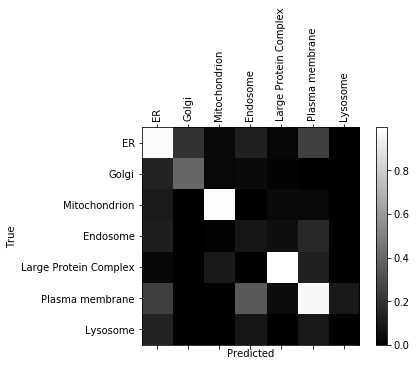

In [30]:
y_pred_test = model.predict(x_test_pad)
y_pred_indices_test = OH_to_label_indices(y_pred_test)
y_pred_label_test = indices_to_cat(y_pred_indices_test)

conf_mx = confusion_matrix(y_test, y_pred_label_test, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=1)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()